# Forecasting Particulate Matter (PM2.5) in Lagos.

Particulate Matter 2.5 (PM2.5) refers to tiny particles or droplets in the air that are two and a half microns or less in width. These particles can pose health risks when inhaled, especially when they are at elevated levels. Understanding the temporal patterns of PM2.5 concentration can provide valuable insights into its sources and potential impacts on human health.

Accurate monitoring of PM2.5 (Particulate Matter 2.5 micrometers or smaller in diameter) is indeed a crucial step towards pollution control, climate change control and overall environmental quality improvement in Lagos,Nigeria. 

Monitoring PM2.5 aligns with international commitments to combat climate change and improve air quality. Lagos, like many regions, may be part of international agreements and initiatives that require reporting on air quality and emissions reduction efforts.

## About the dataset
This dataset is sourced from [openAfrica](https://open.africa/dataset/sensorsafrica-airquality-archive-lagos). 
This data set contains PM (particulate matter), temperature, and humidity readings taken with low-cost sensors. These sensors measure the concentration of PM in the air, including particles with diameters less than or equal to 1 micrometer (PM1), 2.5 micrometers (PM2.5), and particles with diameters less than or equal to 10 micrometers (PM10). The data set includes information on the sensor type, date, time, and location of the readings, as well as the sensor’s specific measurement values for Temperature (C), Humidity (%), PM1, PM2.5, and PM10.


### `Objective of the project`

The objective of this work is to develop a predictive model using dataset of emissions,  to forecast pm2.5 in Lagos. A simple User Interface will be develop for easy navigation.

This work can enable authorities to respond swiftly to pollution events, enforce regulations, and allocate resources efficiently for pollution control and climate change adaptation measures.

# Import Packages

In [131]:
# Import Packages

import warnings
from datetime import datetime
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings("ignore")

# Prepare data

In [180]:
# Read data
file_pattern = "datasets/lagos_air_quality*.csv"

# Get a list of filenames matching the pattern
file_list = glob.glob(file_pattern)

# Iterate over the files
datasets = []
for file in file_list:
    print(file)
    
    # Append file to datasets
    datasets.append(file)

datasets\lagos_air_quality_01.csv
datasets\lagos_air_quality_02.csv
datasets\lagos_air_quality_03.csv
datasets\lagos_air_quality_04.csv
datasets\lagos_air_quality_05.csv


In [181]:
# Looking at the first data
df = pd.read_csv(datasets[1], sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,4857,pms5003,3630,6.54,3.297,2023-12-01T05:32:46.225178+00:00,P2,45.7
1,4857,pms5003,3630,6.54,3.297,2023-12-01T05:32:46.225178+00:00,P1,56.2
2,4857,pms5003,3630,6.54,3.297,2023-12-01T05:32:46.225178+00:00,P0,31.1
3,4858,DHT22,3630,6.54,3.297,2023-12-01T05:33:00.284420+00:00,humidity,100.0
4,4858,DHT22,3630,6.54,3.297,2023-12-01T05:33:00.284420+00:00,temperature,26.3


Now that we have read our data, we will go ahead to clean it up. Since we are only interested in particulate matter (PM2.5), we will filter only the timestamp and pm 2.

In [182]:
def filter_data(data, column1, column2, column3, value, sep=";"):
    
    # Iterate over the datasets
    datasets = []
    for file in data:
        df = pd.read_csv(file, sep=sep)
        
        # Convert timestamp to datetime
        df[column2] = pd.to_datetime(df[column2])
        
        # Filter for pm2
        df = df[df[column1] == value]

        
        # feature engineering
        df["date"] = df[column2].dt.date
        df["weekday"] = df[column2].dt.weekday
        df["hour"] = df[column2].dt.hour
        
        # Convert date to datetime
        df["date"] = pd.to_datetime(df["date"])
        
        # Select features of interest
        df = df[["timestamp","date","weekday","hour",column3 ]]
        
        # Reset index
        df = df.reset_index(drop = True)
        
        # append all files together
        datasets.append(df)
    
    # Join all files together as one table
    pm2_df = pd.concat(datasets, ignore_index=True)
    return pm2_df

In [183]:
pm2_df = filter_data(datasets, "value_type", "timestamp","value", "P2")
pm2_df.head()

,timestamp,date,weekday,hour,value
0,2023-11-01 16:44:52.764459+00:00,2023-11-01,2,16,19.00
1,2023-11-01 17:52:08.924982+00:00,2023-11-01,2,17,3.50
2,2023-11-01 17:53:13.805911+00:00,2023-11-01,2,17,3.00
3,2023-11-01 18:16:42.515782+00:00,2023-11-01,2,18,40.33
4,2023-11-03 07:38:39.664224+00:00,2023-11-03,4,7,47.00


In [184]:
pm2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  36489 non-null  datetime64[ns, UTC]
 1   date       36489 non-null  datetime64[ns]     
 2   weekday    36489 non-null  int32              
 3   hour       36489 non-null  int32              
 4   value      36489 non-null  float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int32(2)
memory usage: 1.1 MB


# EDA

In [186]:
# summary statistics
pm2_df.describe()

,date,weekday,hour,value
count,36489,36489.000000,36489.000000,36489.000000
mean,2024-02-07 20:55:27.994737920,3.169969,12.321878,39.191171
min,2023-11-01 00:00:00,0.000000,0.000000,0.000000
25%,2023-12-29 00:00:00,1.000000,8.000000,20.800000
50%,2024-03-01 00:00:00,3.000000,13.000000,32.000000
75%,2024-03-09 00:00:00,5.000000,17.000000,46.670000
max,2024-03-18 00:00:00,6.000000,23.000000,449.000000
std,NaN,2.079210,6.096342,29.786298


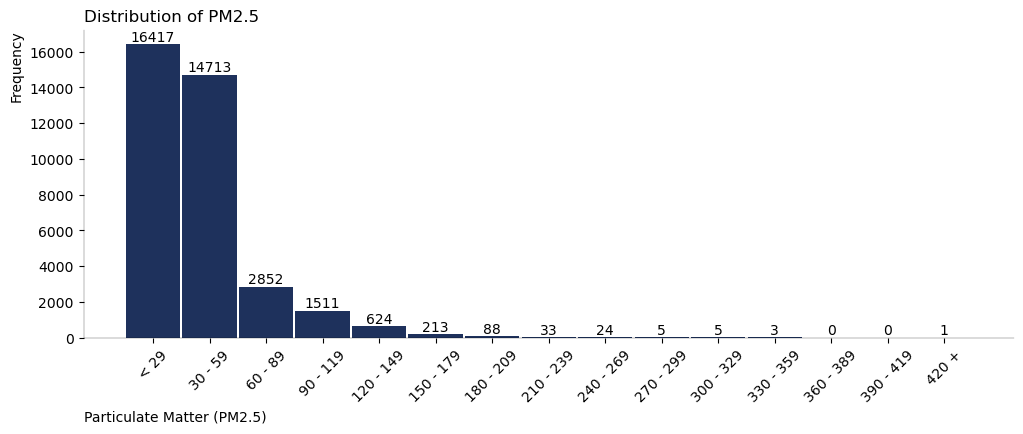

In [187]:
fig, ax = plt.subplots(figsize=(12,4))

# Histogram of height in cm
n, bin_edges, patches = ax.hist(pm2_df.value, rwidth=0.96, bins=15, color="#1E315C")

# Get rid of top horizontal axis line and right vertical axis line
ax.spines[["top","right"]].set_visible(False)
ax.spines[["bottom","left"]].set_linewidth(0.2)

# Axis labels
ax.set_ylabel("Frequency", loc="top")
ax.set_xlabel("Particulate Matter (PM2.5)", loc="left")
ax.set_title("Distribution of PM2.5", loc="left");

# the bin labels:
bin_centers = 0.5 * np.diff(bin_edges) + bin_edges[:-1]

labels = [f"< {bin_edges[1].astype(int)}"]  # The first label
labels += [f"{bin_edges[i].astype(int)+1} - {bin_edges[i + 1].astype(int)}" for i in range(1, len(bin_edges) - 2)]
labels += [f"{bin_edges[-2].astype(int)+1} +"] # The last label

ax.set_xticks(bin_centers, labels, rotation=45)
ax.bar_label(patches);

It is evident from the histogram chart that, the plot is right skewed, meaning that there more of lower values of PM2.5 in the dataset than there are higher values with a peak value of less than 29 µg/m3

Next, we make a boxplot to check for outliers.

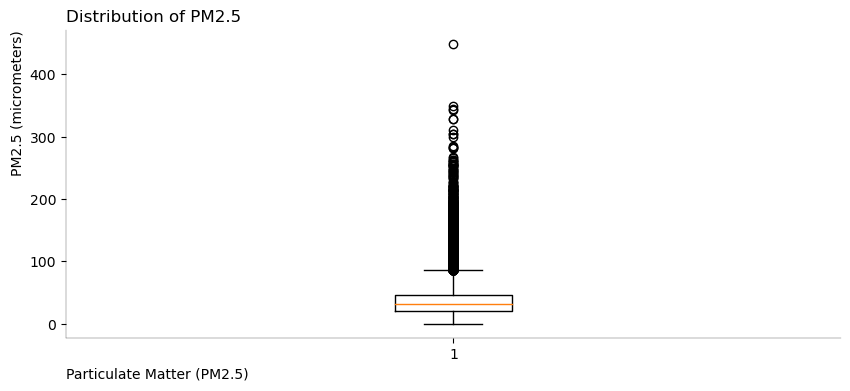

In [188]:
# Make a boxplot
fig, ax = plt.subplots(figsize=(10,4))

ax.boxplot(pm2_df.value)

# Get rid of top horizontal axis line and right vertical axis line
ax.spines[["top","right"]].set_visible(False)
ax.spines[["bottom","left"]].set_linewidth(0.2)

# Axis labels
ax.set_ylabel("PM2.5 (micrometers)", loc="top")
ax.set_xlabel("Particulate Matter (PM2.5)", loc="left")
ax.set_title("Distribution of PM2.5", loc="left");


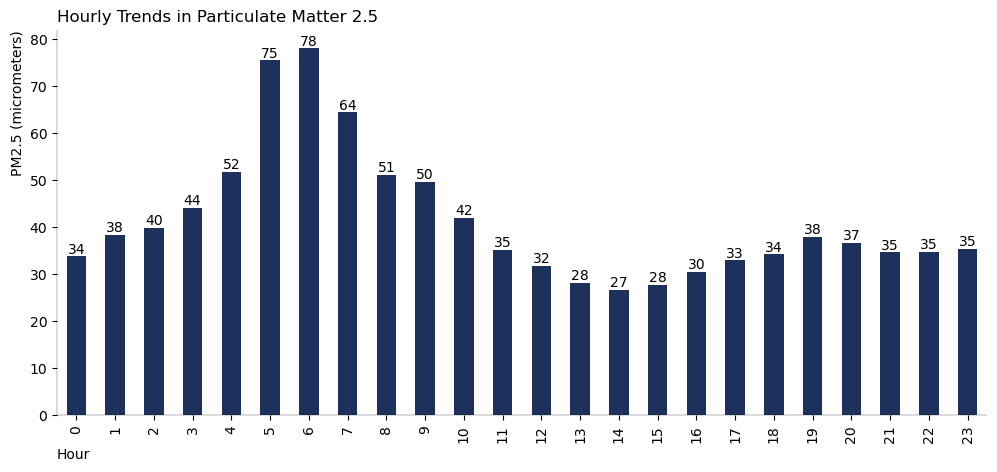

In [189]:
hourly_trend = pm2_df.groupby("hour")["value"].mean()

# Make a line plot of PM2.5
fig, ax = plt.subplots(figsize=(12,5))

# Bar plot
hourly_trend.plot(kind="bar", ax=ax, color="#1E315C")

# Add data labels
mean_values = list(hourly_trend.values)

for i, mean_value in enumerate(mean_values):
    plt.annotate(str(round(mean_value)), xy=(i, mean_value), ha = "center", va = "bottom")

# Get rid of top horizontal axis line and right vertical axis line
ax.spines[["top","right"]].set_visible(False)
ax.spines[["bottom","left"]].set_linewidth(0.2)


# Axis labels
ax.set_ylabel("PM2.5 (micrometers)", loc="top")
ax.set_xlabel("Hour", loc="left")
ax.set_title("Hourly Trends in Particulate Matter 2.5", loc="left");

The analysis of hourly trends reveals distinct temporal patterns over the course of a typical day. PM2.5 concentration exhibits a morning peak between 5 AM and 9 AM, possibly due to increased vehicular activity during the morning commute and the onset of industrial operations. A late morning decrease from 10 AM to 2 PM is observed, likely due to reduced traffic and favorable weather conditions promoting atmospheric dispersion. An evening peak from 3 PM to 7 PM coincides with the evening commute and domestic activities such as cooking, contributing to elevated PM2.5 levels. Late night and early morning hours experience a decrease in PM2.5 concentration, likely influenced by reduced human activity and atmospheric stability. These findings underscore the dynamic interplay between human activities, atmospheric conditions, and PM2.5 concentration levels.

In [190]:
# Map the week numbers to their corresponding names

week_names = {0 : "Monday",
           1 : "Tuesday",
           2 : "Wednesday",
           3 : "Thursday",
           4 : "Friday",
           5 : "Saturday",
           6 : "Sunday"}

pm2_df["week_name"] = pm2_df["weekday"].map(week_names)

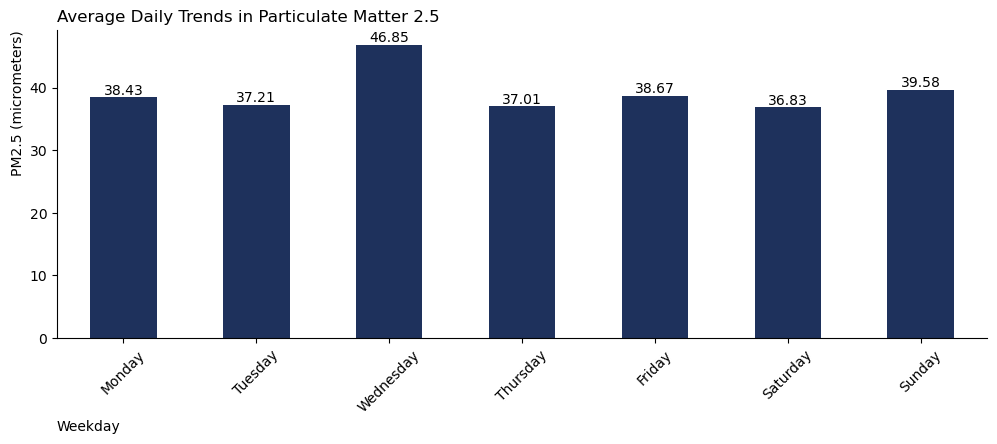

In [191]:
# Calculate the mean PM2.5 value for each day of the week
daily_trend = pm2_df.groupby("week_name")["value"].mean()

# Define the desired order of weekdays
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Reorder the index of the daily_trend Series
daily_trend_sorted = daily_trend.reindex(week_order)

# Make a bar plot of PM2.5
fig, ax = plt.subplots(figsize=(12, 4))

# Bar plot
daily_trend_sorted.plot(kind="bar", ax=ax, color="#1E315C")

# Add data labels
mean_values = list(daily_trend_sorted.values)
for i, mean_value in enumerate(mean_values):
    plt.annotate(str(round(mean_value, 2)), xy=(i, mean_value), ha="center", va="bottom")

# Get rid of top horizontal axis line and right vertical axis line
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set axis labels and title
ax.set_ylabel("PM2.5 (micrometers)", loc="top")
ax.set_xlabel("Weekday", loc="left")
ax.set_title("Average Daily Trends in Particulate Matter 2.5", loc="left")

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=45)

## Resampling

Here, we are interested in predicting the hourly PM 2.5. Therefore, we will downsample to hourly observations.

In [192]:
# Drop unnecesary features
pm2_df = pm2_df.drop(columns=["week_name","weekday", "date", "hour"],axis=1)
pm2_df.set_index('timestamp', inplace=True)

# Daily Resampling
daily_data = pm2_df.resample('D').mean().fillna(method='ffill')  # fill missing values with forward fill
daily_data.head()

,value
timestamp,
2023-11-01 00:00:00+00:00,16.457500
2023-11-02 00:00:00+00:00,16.457500
2023-11-03 00:00:00+00:00,36.068019
2023-11-04 00:00:00+00:00,36.068019
2023-11-05 00:00:00+00:00,36.068019


In [193]:
# Check for null values
daily_data.isna().sum()

value    0
dtype: int64

In [194]:
daily_data.shape

(139, 1)

In [196]:
daily_data = daily_data.squeeze()
daily_data.head()

timestamp
2023-11-01 00:00:00+00:00    16.457500
2023-11-02 00:00:00+00:00    16.457500
2023-11-03 00:00:00+00:00    36.068019
2023-11-04 00:00:00+00:00    36.068019
2023-11-05 00:00:00+00:00    36.068019
Freq: D, Name: value, dtype: float64

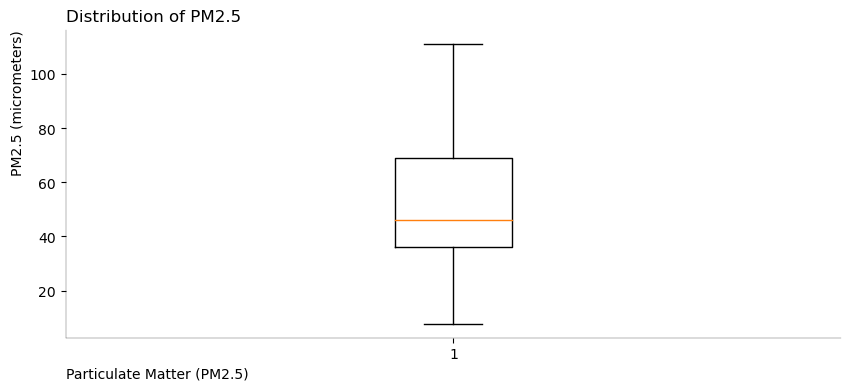

In [197]:
# Make a boxplot
fig, ax = plt.subplots(figsize=(10,4))

ax.boxplot(daily_data)

# Get rid of top horizontal axis line and right vertical axis line
ax.spines[["top","right"]].set_visible(False)
ax.spines[["bottom","left"]].set_linewidth(0.2)

# Axis labels
ax.set_ylabel("PM2.5 (micrometers)", loc="top")
ax.set_xlabel("Particulate Matter (PM2.5)", loc="left")
ax.set_title("Distribution of PM2.5", loc="left");


# Stationarity

Before forecasting, we want our time series variables to be mean-variance stationery. This means that the statistical properties of a model do not vary depending on when the sample was taken. Models built on stationary data are generally more robust. This can be achieved by using differencing.

Here, we will use **`ACF plot, PACF plot`** and **`Adfuller Test`** to find out if our data is stationary or not.

In [199]:
# Adfuller test

pval =  adfuller(daily_data)
print(f"pval: {pval[1]}")

pval: 0.02133888812541542


Great! The Dicky-Fuller test says that the series is stationary.

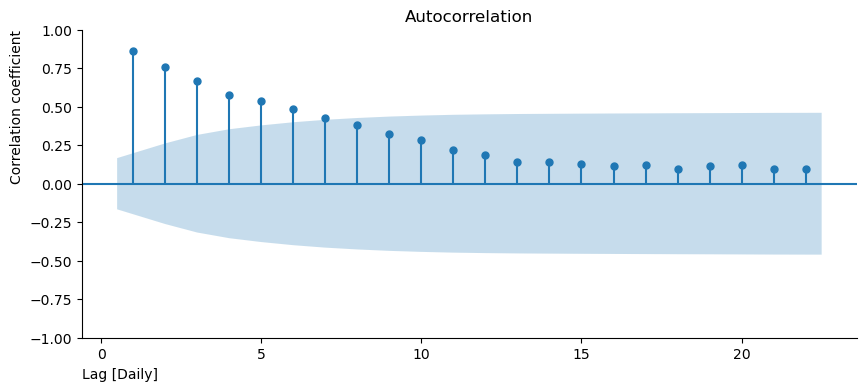

In [200]:
# ACF plot

fig, ax = plt.subplots(figsize=(10,4))
plot_acf(daily_data, zero=False, ax=ax)

# Get rid of top horizontal axis line and right vertical axis line
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set axis labels and title
ax.set_ylabel("Correlation coefficient", loc="top")
ax.set_xlabel('Lag [Daily]', loc="left");

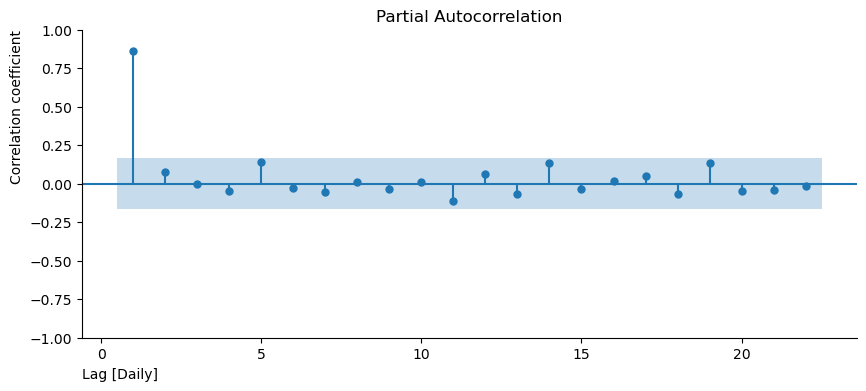

In [201]:
# ACF plot

fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(daily_data, zero=False, ax=ax)

# Get rid of top horizontal axis line and right vertical axis line
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set axis labels and title
ax.set_ylabel("Correlation coefficient", loc="top")
ax.set_xlabel('Lag [Daily]', loc="left");

From the results of `AdFuller test`, we find out that the `p-value` is less than `0.5`, therefore we fail to reject the `null value` that the `times series data is stationary`.

Again, the `ACF plot` above decays gradually which also points to the fact the data is stationary.  

Next, we split the dataset and prepare it for modeling.

# Split dataset


In [202]:
# split data

cut_off = int(len(daily_data) *0.8) # series data is split chronologically in a horizontal manner
y_train = daily_data.iloc[:cut_off]
y_test =  daily_data.iloc[cut_off:]

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (111,)
y_test shape: (28,)


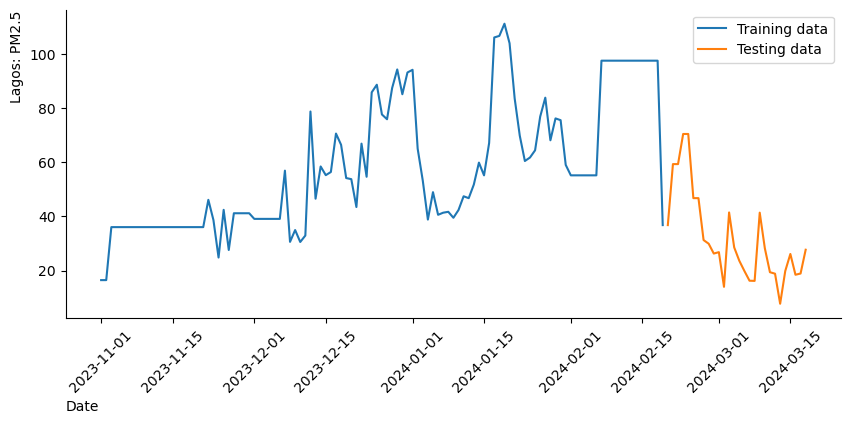

In [203]:
import matplotlib.dates as mdates
# plot training and test data

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(y_train,label='Training data')
ax.plot(y_test, label='Testing data')

# Get rid of top horizontal axis line and right vertical axis line
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set axis labels and title
ax.set_ylabel('Lagos: PM2.5', loc="top")
ax.set_xlabel('Date', loc="left")

# Set x-axis ticks more readable
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Add legend
ax.legend(loc='upper right')

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=45);

# Build Model

### Baseline Model

In [207]:
y_mean = y_train.mean()
y_pred_baseline= [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f"Mean Price: {round(y_mean,2)}")
print(f"MAE Baseline: {round(mae_baseline,2)}")

Mean Price: 58.22
MAE Baseline: 20.48


# Fit

Since there is a weekly trend present in our data, we will model our data using SARIMAX model. This weekly trend can be captured and analyzed where the model includes a seasonal component with a weekly period. By incorporating this weekly seasonality into the model, it can better capture and forecast the observed patterns in the data.

In [367]:
# Define SARIMAX model
order = (2, 1, 2)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, S)
model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)

# Fit SARIMAX model
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(y_test))

### Evaluate the model

Before we use the model to predict, we want to know how accurate our predictions are. The mean absolute error (MAE) is a good statistic for this. It is the mean difference between your predictions and the true values. We will calculate the `mean absolute error` from the `model residals`.

In [368]:
# Calculate the mean absolute error 
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute error: {round(mae,2)}")

Mean Absolute error: 16.18


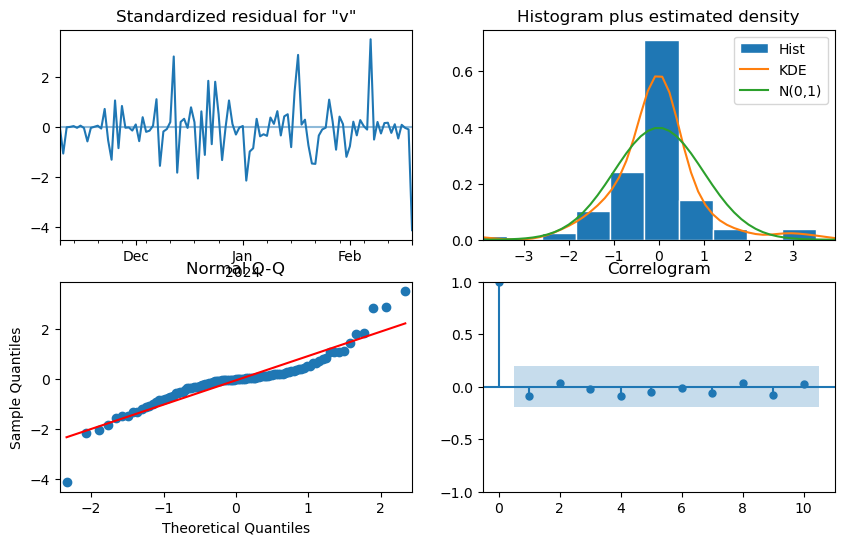

In [365]:
# Model Diagnostics
ax = fitted_model.plot_diagnostics(figsize=(10,6));

# Predict Test data

In [371]:
# Generate predictions for the test data
forecast = fitted_model.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, typ="levels")

## Communicate Result

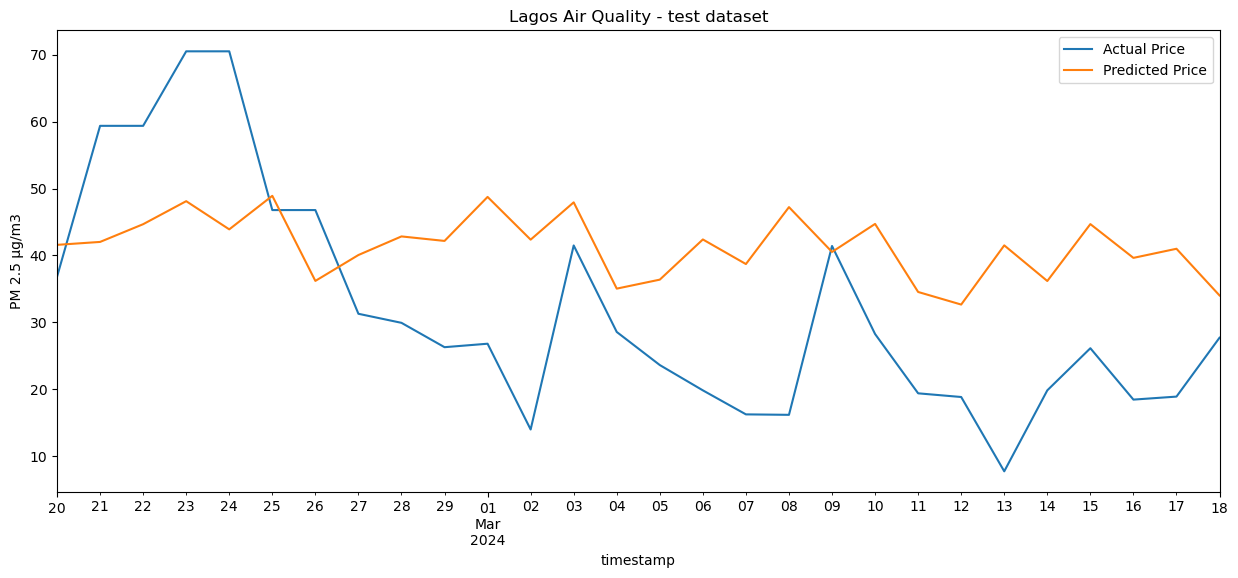

In [372]:
# build a dataframe of the testing data model result

result_df = pd.DataFrame({"Actual Price":y_test,
                      "Predicted Price":forecast},
                     index = y_test.index)

# make a plot of the result

fig, ax = plt.subplots(figsize=(15,6))
# make a plot of the result
result_dfs.plot(ax=ax)
plt.title("Lagos Air Quality - test dataset")
plt.ylabel("PM 2.5 µg/m3");

# Future Forecast

In [375]:
# Get forecast for the next 10 periods
n_periods = 10
arima_pred = fitted_model.get_forecast(steps=n_periods)

# get forecasted values
forecast_values = arima_pred.predicted_mean.round(2)

# build dataframe of forecast values
forecast_values.index = pd.date_range(start=pm2_df.index[-1],
                                  periods=n_periods+1)[1:] # starts from the next day after last day in the dataset 

# rename the index
forecast_values.index.rename("future_date", inplace=True)

print("\n\nForecast of Daily Lagos Air Quality")
forecast_values.head()



Forecast of Daily Lagos Air Quality


future_date
2024-03-19 18:53:20.437257+00:00    41.59
2024-03-20 18:53:20.437257+00:00    42.03
2024-03-21 18:53:20.437257+00:00    44.68
2024-03-22 18:53:20.437257+00:00    48.12
2024-03-23 18:53:20.437257+00:00    43.91
Freq: D, Name: predicted_mean, dtype: float64

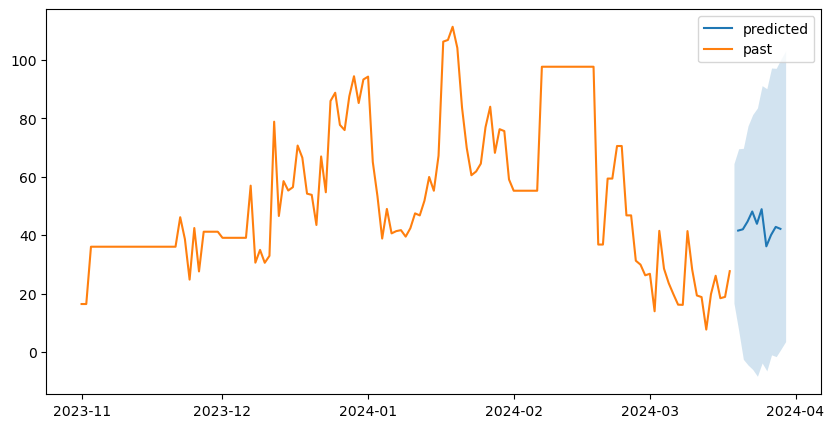

In [376]:
plt.figure(figsize=(10,5))

# Plot past CO2 levels
plt.plot(forecast_values.index, forecast_values, label='predicted')

# Plot the prediction means as line
plt.plot(daily_data.index, daily_data, label='past')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()

## Conclusion

1. While the **`WHO`** guideline for the annual mean PM 2.5 concentration level is 5 µg/m3 and 24-hour average exposures should not exceed 15µg/m3 more than 3-4 days per year, the average hourly PM 2.5 concentration in Lagos has been above the WHO baseline every day up to the last day in the dataset.

2. The data is modelled using SARIMAX since there is a presence of weekly trend in the dataset.
3. A mean absolute value of 16.8µg/m3 was achieved as against 20.48 µg/m3 baseline error
4. The model was deployed to the cloud using Streamlit for easy navigation and prediction by end users.

In [2]:
! pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
